<a href="https://colab.research.google.com/github/HerinePamela/Notebook/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pamelaauma","key":"bf2e8b9a34934e1f50afa7493123a436"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the kaggle dataset
# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:20<00:00, 139MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip

In [ ]:
# reading the dataset
import cv2
import numpy as np
import os

class ReadDataset:
    def __init__(self, dataset_dir, labels, image_shape):
        self.dataset_dir = dataset_dir
        self.labels = labels
        self.image_shape = image_shape
        self.images = self.load_images()

    def load_images(self):
        images = {}
        for label in self.labels:
            label_dir = os.path.join(self.dataset_dir, label)
            image_files = [os.path.join(label_dir, file) for file in os.listdir(label_dir) if not file.startswith('.')]
            images[label] = image_files
        return images

    def read_images(self):
        all_images = []
        all_labels = []
        for label in self.labels:
            for img_path in self.images[label]:
                img = cv2.imread(str(img_path))
                if img is not None:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img / 255.0
                    all_images.append(img)
                    all_labels.append(label)
                else:
                    print("Error: Failed to load image from", img_path)
        return np.array(all_images), np.array(all_labels)


dataset_dir = "/content/chest_xray/chest_xray/train"
labels = ['NORMAL', 'PNEUMONIA']
image_shape = (64, 64)

df = ReadDataset(dataset_dir, labels, image_shape)
images, labels = df.read_images()

images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

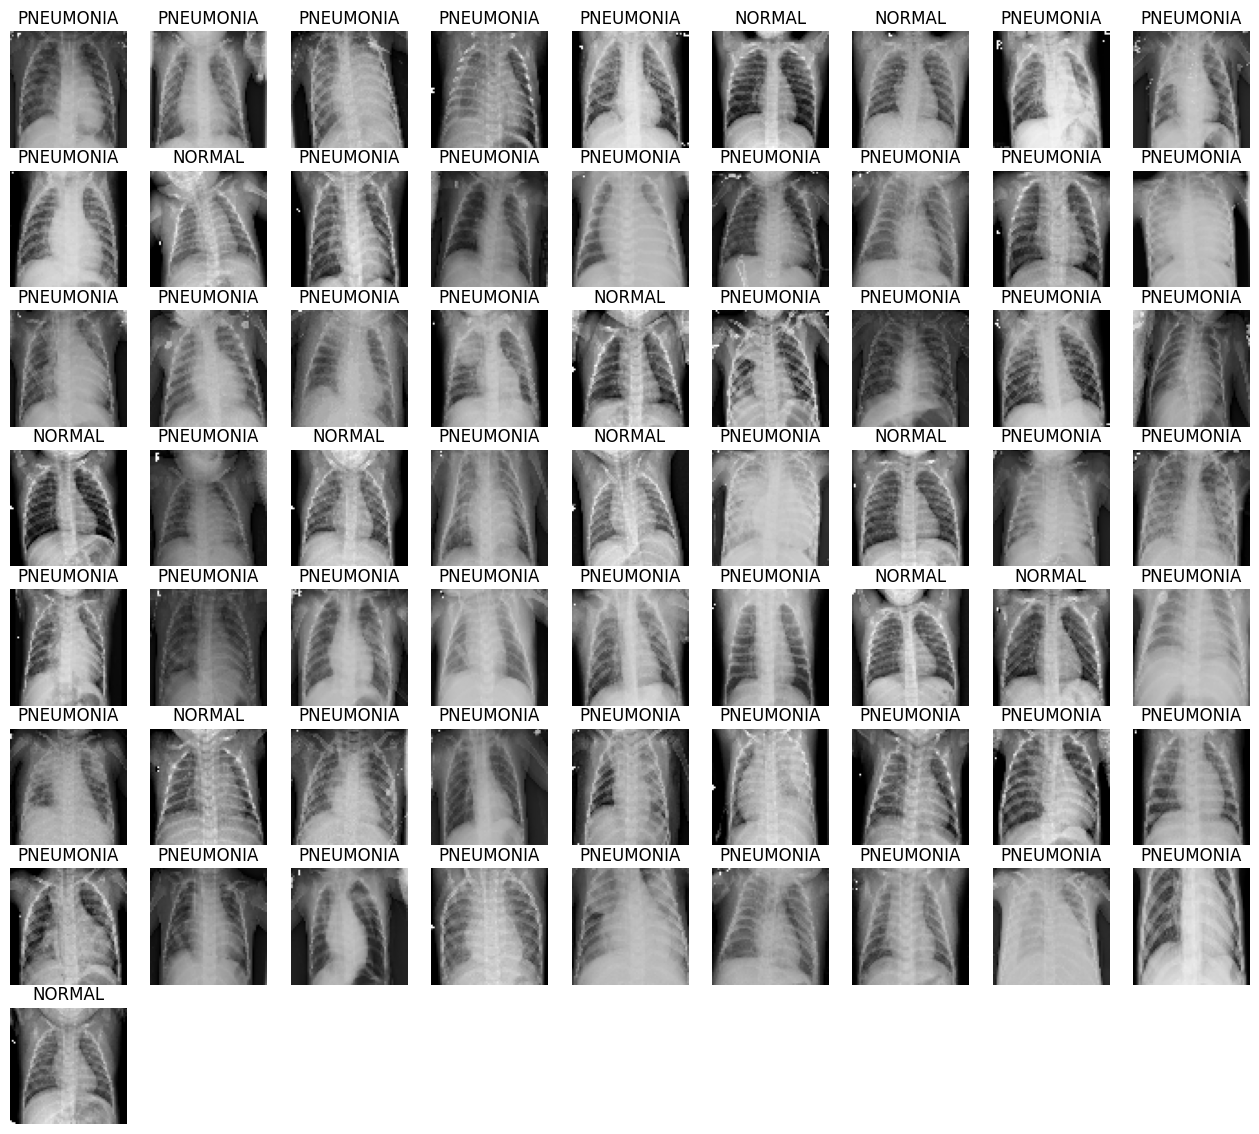

In [ ]:
#  plotting images in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize = (16, 16))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(9, 9, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
    plt.axis('off')
plt.show()

In [ ]:
# TRAINING OF THE ACGAN MODEL- it helps in training the geneereator to produce images thata visually appealing and belong to the correct class.
import tensorflow as tf
from keras import models
from tensorflow.keras import layers
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        # Initializing the ACGAN parameters
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size

    def data(self, images, labels):
        # Preparing data for training
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        # Generating samples from the generator model
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        # Visualizing generated images
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()

    def generator(self, inputs, labels):
        # Defining the generator model architecture
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024)(x)
        x = layers.Dense(8 * 8 * filters[0],
                         kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding,
                                strides=strides)(x)
        x = Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels],
                                            outputs=x,
                                            name='generator')

    def discriminator(self, inputs):
        # Defining the discriminator model architecture
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding,
                       strides=strides,
                       kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256,
                             kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2, )(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs,
                                                outputs=[outputs, labelsOutput],
                                                name='discriminator')

    def build(self,):
        # Building the ACGAN model
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta,
                                                          weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput],
                           outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta * 0.5,
                                                          weight_decay=self.weight_decay * 0.5))
        GAN.summary()
        return G, D, GAN

    def trainAlgorithm(self, G, D, GAN):
        # Training ACGAN model
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size, ))
            noize = tf.random.uniform(shape=(self.batch_size,
                                              self.latent_space), minval=-1,
                                     maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size,)),
                                                      num_classes=2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose=0))
            fakeTag = tf.zeros(shape=(self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size,
                                              self.latent_space), minval=-1,
                                     maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                # Print discriminator and generator losses
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                 # Generate and display sample images
                self.samples(G, noize, fakeLabels)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initializing label encoder
label_encoder = LabelEncoder()

# Encoding string labels into numerical values
encoded_labels = label_encoder.fit_transform(labels)

# Creating an instance of the ACGAN class
acgan = Acgan(eta=0.0001, batch_size=32, epochs=5000, weight_decay=6e-9,
              latent_space=128, image_shape=(64, 64, 3), kernel_size=3)

# Preparing data for training
acgan.data(images, encoded_labels)

# Building the ACGAN model
G, D, GAN = acgan.build()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['leaky_re_lu[0][0]']         
                                                                                      

Epoch: 0
discriminator loss: [tag: 0.5212963819503784, labels: 0.6942499876022339], generator loss: [tag: 0.6945679187774658, labels: 0.698928952217102]
1/1 [==============================] - 1s 1s/step


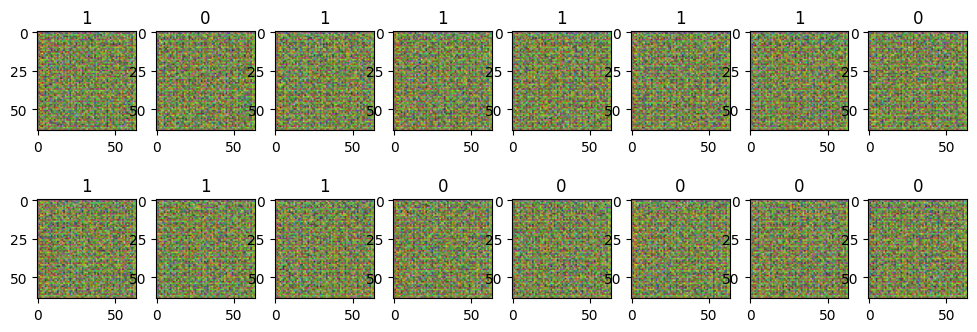

In [ ]:
acgan.trainAlgorithm(G, D, GAN)

In [ ]:
# saving the generator model
G.save('/content/data')

In [ ]:
G = tf.keras.models.load_model('/content/data')

In [ ]:
# generating synthetic data consisting of random noise features and corresponding binary labels
datasetGenerationSize = 5000
noize = tf.random.uniform(shape = (datasetGenerationSize, 128), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [ ]:
noize.shape, newlabels.shape

(TensorShape([5000, 128]), (5000, 2))

In [ ]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([2477, 2523]))

In [ ]:
imgGen = G.predict([noize, newlabels])
imgGen.shape

157/157 [==============================] - 126s 803ms/step


(5000, 64, 64, 3)

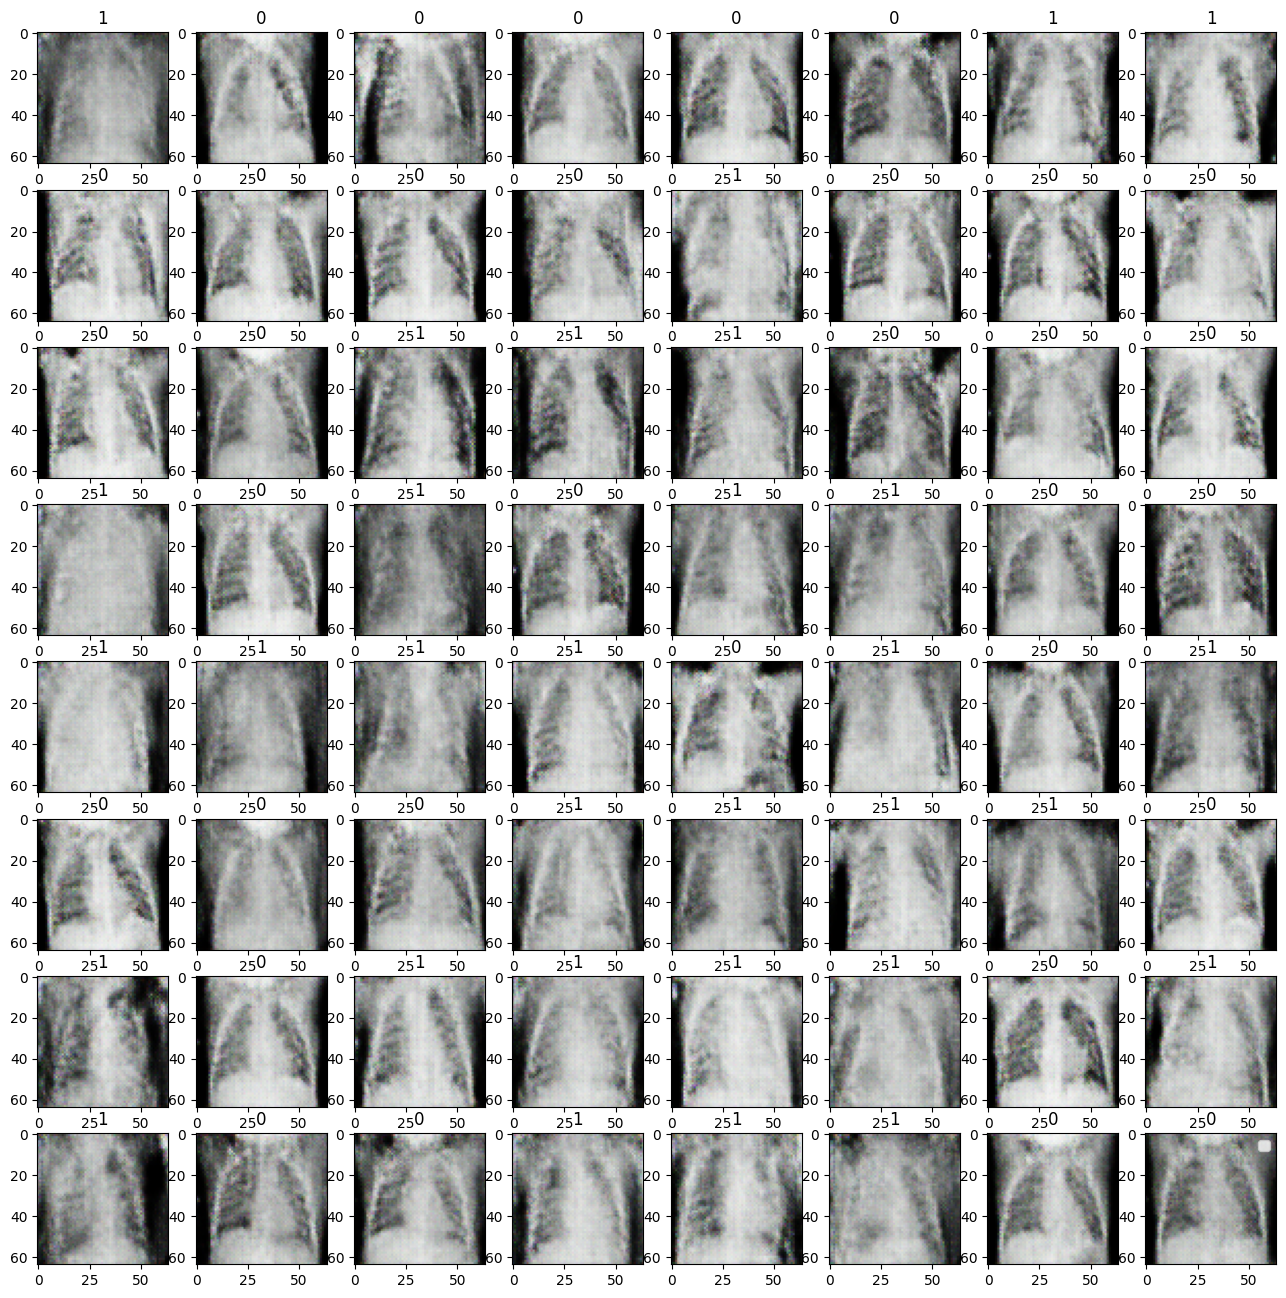

In [ ]:
# visualizing the generated images
plt.figure(figsize = (16, 16))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imgGen[i])
    plt.title(t[i])
plt.legend()

In [ ]:
# Creating a neural network model for binary classification using transfer learning with the VGG16 architecture as the base model

basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
# training the defined neural network model

history = m.fit(imgGen, np.argmax(newlabels, axis = 1),
                epochs = 5, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/5
63/63 [==============================] - 784s 12s/step - loss: 0.6248 - val_loss: 0.6918
Epoch 2/5
63/63 [==============================] - 744s 12s/step - loss: 0.2344 - val_loss: 0.6861
Epoch 3/5
63/63 [==============================] - 743s 12s/step - loss: 0.1288 - val_loss: 0.6744
Epoch 4/5
63/63 [==============================] - 743s 12s/step - loss: 0.1041 - val_loss: 0.6492
Epoch 5/5
63/63 [==============================] - 739s 12s/step - loss: 0.0867 - val_loss: 0.6011


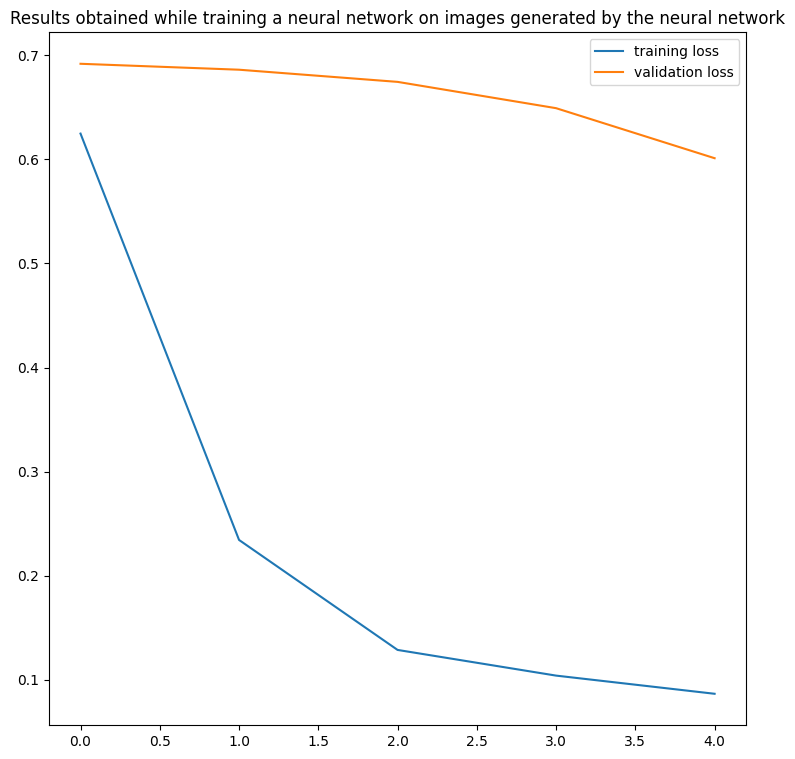

In [ ]:
# Ploting the training and validation loss curves

plt.figure(figsize = (9, 9))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [ ]:

# evaluating the trained neural network model
m.evaluate(images, labels)

UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-6069b7b542b7>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_test_function_594607]

In [ ]:
# Making predictions using the trained neural network model
y_prediction = tf.squeeze(m.predict(images))
y_prediction .shape

 18/163 [==>...........................] - ETA: 3:46

In [ ]:
y_prediction  = y_prediction  >= 0.7
y_prediction  = np.array(y_prediction , dtype = 'int32')
y_prediction

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Calculating accuracy of the predictions

accuracy_score(y_prediction , labels)*100

In [ ]:
print(classification_report(y_prediction , labels))

In [ ]:
# Computing the confusion matrix based on the predictions

from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_m = confusion_matrix(y_prediction , labels)
conf_m

In [ ]:
# creating a DataFrame representation of the confusion matrix,

import pandas as pd
conf_mObject = pd.DataFrame(conf_m , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
conf_mObject.head()

In [ ]:
# Calculating and printing F1 score, recall, and precision metrics for the predictions

from sklearn.metrics import f1_score, recall_score, precision_score

print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_prediction, labels)*100,
                                                                   recall_score(y_prediction, labels)*100,
                                                                   precision_score(y_prediction, labels)*100))